In [25]:
import numpy as np
import re
import plotly
plotly.tools.set_credentials_file(username='sarahhow', api_key='QyYv61byWAKjjpB0DH6T')
plotly.tools.set_config_file(world_readable=False,
                             sharing='private')
import plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
import glob
import ternary
import datetime as dt
import matplotlib as plt

# Getting all ratios into one dataframe

In [2]:
allratios = pd.DataFrame(columns = ['user','tweet_id','happ_score', 'happ_words', 'likes', 'replies',
       'retweets', 'scrape_date', 'total_words', 'tweet_date','url'])
allratiofiles = glob.glob('ratios/*')
#print('All of the users we have ratios & tweet reply conversations for:')
for file in allratiofiles:
    sname = re.search('(?<=ratios/).*(?=-ratios.csv)',file).group(0)
    #print(sname)
    rdf = pd.read_csv(file)
    rdf = rdf.drop("Unnamed: 0",axis=1)
    rdf = rdf.dropna(axis=0, how='any')
    rdf['user'] = sname
    allratios = pd.concat([allratios,rdf],ignore_index=True)

for tID in list(allratios['tweet_id']):
    subset = allratios.loc[allratios['tweet_id'] == tID]
    if len(subset.index) == 2:
        hapwords = subset['happ_words']
        drop = subset.index[subset['happ_words']== min(hapwords)]
        allratios = allratios.drop(drop, axis=0)
    elif len(subset.index) > 2:
        pass
        print('dulicate tweet! ',list(subset.index))
        
    
for i in allratios.index:
    try:
        allratios.loc[i,'replies'] = float(allratios.loc[i,'replies'])
    except:
        allratios.loc[i,'replies'] = float(allratios.loc[i,'replies'][:-1])*1000
    if allratios.loc[i,'happ_words'] < 200:
        allratios.loc[i,'happ_score'] = np.nan
        
allratios['norm_replies'] = allratios['replies']/(allratios['replies'] + allratios['retweets'] + allratios['likes'])
allratios['norm_likes'] = allratios['likes']/(allratios['replies'] + allratios['retweets'] + allratios['likes'])
allratios['norm_retweets'] = allratios['retweets']/(allratios['replies'] + allratios['retweets'] + allratios['likes'])
'''
allratios['tweet'] = ""
tweetfiles = glob.glob('tweet_convos/*/*')
for i in allratios.index:
    file = [f for f in tweetfiles if str(allratios.loc[i,'tweet_id']) in str(f)]
    #print(file)
    for f in file:
        if 'convo-' in f:
            pass
        else:
            tweetstring = open(f,'r',encoding = 'utf-8')
            allratios.loc[i,'tweet'] = tweetstring.read()
'''        

'\nallratios[\'tweet\'] = ""\ntweetfiles = glob.glob(\'tweet_convos/*/*\')\nfor i in allratios.index:\n    file = [f for f in tweetfiles if str(allratios.loc[i,\'tweet_id\']) in str(f)]\n    #print(file)\n    for f in file:\n        if \'convo-\' in f:\n            pass\n        else:\n            tweetstring = open(f,\'r\',encoding = \'utf-8\')\n            allratios.loc[i,\'tweet\'] = tweetstring.read()\n'

## Finding the most and least happy tweet convo

In [3]:
happmin = min(list(allratios['happ_score']))
happmax = max(list(allratios['happ_score']))   
screenname_least = allratios.loc[allratios.happ_score == happmin,'user'].item()
screenname_most = allratios.loc[allratios.happ_score ==happmax,'user'].item()
tweetid_least = allratios.loc[allratios.happ_score == happmin,'tweet_id'].item()
tweetid_most = allratios.loc[allratios.happ_score ==happmax,'tweet_id'].item()

print('least happy reply thread got a score of ',happmin,' from ',screenname_least,' @ ',str(allratios.loc[allratios.happ_score == happmin,'url'].item()))
print(' w/ a ratio of: R=',str(allratios.loc[allratios.happ_score == happmin,'replies'].item()),'; RT=',str(allratios.loc[allratios.happ_score == happmin,'retweets'].item()),'; L=',str(allratios.loc[allratios.happ_score == happmin,'likes'].item()),)
print(' and it said: ')
print('most happy reply thread got a score of ',happmax,' from ',screenname_most,' @ ',str(allratios.loc[allratios.happ_score == happmax,'url'].item()))
print(' w/ a ratio of: R=',str(allratios.loc[allratios.happ_score == happmax,'replies'].item()),'; RT=',str(allratios.loc[allratios.happ_score == happmax,'retweets'].item()),'; L=',str(allratios.loc[allratios.happ_score == happmax,'likes'].item()),)


least happy reply thread got a score of  4.62264705883  from  marcorubio  @  http://twitter.com/marcorubio/status/986369469734940672
 w/ a ratio of: R= 461.0 ; RT= 8968 ; L= 10428
 and it said: 
most happy reply thread got a score of  7.38128  from  SenatorBaldwin  @  http://twitter.com/SenatorBaldwin/status/804804406495608834
 w/ a ratio of: R= 101.0 ; RT= 2521 ; L= 3768


In [50]:
# Adding the senators non-scraped tweet ratios for a better computation of their average
# #hugedataset #beware
senators = pd.read_csv('senators.csv',encoding='latin-1')
senators['likes'] = senators['favorites']
senators['tweet_id'] = [re.search('(?<=status/).*',senators.loc[i,'url']).group(0) for i in senators.index]
senators.set_index('tweet_id')
allratios.set_index('tweet_id')
senators = senators.drop([i for i in allratios.index if i in senators.index])
senators = senators.drop([i for i in senators.index if senators.loc[i,'replies'] < 10 or senators.loc[i,'retweets'] < 10 or senators.loc[i,'likes'] < 10],axis=0)
senators['norm_replies'] = senators['replies']/(senators['replies']+senators['retweets']+senators['likes'])
senators['norm_retweets'] = senators['retweets']/(senators['replies']+senators['retweets']+senators['likes'])
senators['norm_likes'] = senators['likes']/(senators['replies']+senators['retweets']+senators['likes'])
senators['group']= ['senators_'+str(senators.loc[i,'party']) for i in senators.index]
senators_D = list(set(senators.loc[senators.group=='senators_D','user']))
senators_R = list(set(senators.loc[senators.group=='senators_R','user']))
senators_R.append('SenateMajLdr')
senators_I = list(set(senators.loc[senators.group=='senators_I','user']))
senators['tweet_date'] = [str('20'+re.search('(?<=\/)..(?= )',senators.loc[i,'created_at']).group(0)+'-'+
                            "%02d"%int(re.search('^.{1,2}(?=\/)',senators.loc[i,'created_at']).group(0))+'-'+
                            "%02d"%int(re.search('(?<=\/).{1,2}(?=\/)',senators.loc[i,'created_at']).group(0)))
                         for i in senators.index]
senators['tweet'] = senators['text']
senators = senators.drop(labels=['favorites','text','created_at','bioguide_id','party','state'],axis=1) 
senators['happ_score'] = np.nan
senators['happ_words'] = np.nan
senators['total_words'] = np.nan
senators['scrape_date'] = np.nan
allratios['group'] = np.nan

obama = pd.read_csv('obama.csv',encoding='latin-1')
obama['tweet_id'] = [re.search('(?<=status/).*',obama.loc[i,'url']).group(0) for i in obama.index]
obama.set_index('tweet_id')
obama = obama.drop([i for i in allratios.index if i in obama.index])
obama['likes'] = obama['favorites']
obama = obama.drop([i for i in obama.index if obama.loc[i,'replies'] < 10 or obama.loc[i,'retweets'] < 10 or obama.loc[i,'likes'] < 10],axis=0)
obama['norm_replies'] = obama['replies']/(obama['replies']+obama['retweets']+obama['likes'])
obama['norm_retweets'] = obama['retweets']/(obama['replies']+obama['retweets']+obama['likes'])
obama['norm_likes'] = obama['likes']/(obama['replies']+obama['retweets']+obama['likes'])
obama['group']= 'POTUSes'
obama['tweet_date'] = [str('20'+re.search('(?<=\/)..(?= )',obama.loc[i,'created_at']).group(0)+'-'+
                            "%02d"%int(re.search('^.{1,2}(?=\/)',obama.loc[i,'created_at']).group(0))+'-'+
                            "%02d"%int(re.search('(?<=\/).{1,2}(?=\/)',obama.loc[i,'created_at']).group(0)))
                         for i in obama.index]
obama['tweet'] = obama['text']
obama = obama.drop(labels=['favorites','text','created_at'],axis=1) 
obama['happ_score'] = np.nan
obama['happ_words'] = np.nan
obama['total_words'] = np.nan
obama['scrape_date'] = np.nan

trump = pd.read_csv('trump.csv',encoding='latin-1')
trump['tweet_id'] = [re.search('(?<=status/).*',trump.loc[i,'url']).group(0) for i in trump.index]
trump.set_index('tweet_id')
trump = trump.drop([i for i in allratios.index if i in trump.index])
trump['likes'] = trump['favorites']
trump = trump.drop([i for i in trump.index if trump.loc[i,'replies'] < 10 or trump.loc[i,'retweets'] < 10 or trump.loc[i,'likes'] < 10],axis=0)
trump['norm_replies'] = trump['replies']/(trump['replies']+trump['retweets']+trump['likes'])
trump['norm_retweets'] = trump['retweets']/(trump['replies']+trump['retweets']+trump['likes'])
trump['norm_likes'] = trump['likes']/(trump['replies']+trump['retweets']+trump['likes'])
trump['group']= 'POTUSes'
trump['tweet_date'] = [str('20'+re.search('(?<=\/)..(?= )',trump.loc[i,'created_at']).group(0)+'-'+
                            "%02d"%int(re.search('^.{1,2}(?=\/)',trump.loc[i,'created_at']).group(0))+'-'+
                            "%02d"%int(re.search('(?<=\/).{1,2}(?=\/)',trump.loc[i,'created_at']).group(0)))
                         for i in trump.index]
trump['tweet'] = trump['text']
trump = trump.drop(labels=['favorites','text','created_at'],axis=1) 
trump['happ_score'] = np.nan
trump['happ_words'] = np.nan
trump['total_words'] = np.nan
trump['scrape_date'] = np.nan

allratiosplus = pd.concat([allratios,senators,obama,trump])
allratioswhapp = allratios.drop([i for i in allratios.index if np.isnan(allratios.loc[i,'happ_score'])])


url  replies  retweets  \
94    https://twitter.com/realDonaldTrump/status/918...    24130     11952   
146   https://twitter.com/realDonaldTrump/status/917...    23638     13732   
181   https://twitter.com/realDonaldTrump/status/915...    23755     14954   
187   https://twitter.com/realDonaldTrump/status/915...     3329     14913   
190   https://twitter.com/realDonaldTrump/status/915...     4211      7441   
200   https://twitter.com/realDonaldTrump/status/914...    26923     18311   
203   https://twitter.com/realDonaldTrump/status/914...    44258      7462   
204   https://twitter.com/realDonaldTrump/status/914...    28210     32320   
205   https://twitter.com/realDonaldTrump/status/914...    55816     27420   
206   https://twitter.com/realDonaldTrump/status/914...    15898     13107   
213   https://twitter.com/realDonaldTrump/status/914...     5578     13478   
225   https://twitter.com/realDonaldTrump/status/914...    53293     15541   
227   https://twitter.com/realDonaldTrump/status/913...     3907      7609   
228   https://twitter.com/realDonaldTrump/status/913...     3950      8038   
231   https://twitter.com/realDonaldTrump/status/913...     3243      6008   
233   https://twitter.com/realDonaldTrump/status/913...     3295      5522   
238   https://twitter.com/realDonaldTrump/status/913...     7408     10373   
247   https://twitter.com/realDonaldTrump/status/913...     4503      9735   
251   https://twitter.com/realDonaldTrump/status/913...    18618     17999   
253   https://twitter.com/realDonaldTrump/status/913...    20891     17810   
259   https://twitter.com/realDonaldTrump/status/913...    12393     10130   
263   https://twitter.com/realDonaldTrump/status/912...    27213     43867   
266   https://twitter.com/realDonaldTrump/status/912...     4361      8573   
268   https://twitter.com/realDonaldTrump/status/912...    11298     10653   
270   https://twitter.com/realDonaldTrump/status/912...     2918      8317   
271   https://twitter.com/realDonaldTrump/status/912...     6009      7023   
273   https://twitter.com/realDonaldTrump/status/912...     9792     14106   
281   https://twitter.com/realDonaldTrump/status/912...    26469     13531   
282   https://twitter.com/realDonaldTrump/status/912...    41682     26981   
283   https://twitter.com/realDonaldTrump/status/912...    35270     22126   
...                                                 ...      ...       ...   
2213  https://twitter.com/realDonaldTrump/status/798...    15480     37897   
2214  https://twitter.com/realDonaldTrump/status/798...    20030     48056   
2218  https://twitter.com/realDonaldTrump/status/797...     6288     22024   
2222  https://twitter.com/realDonaldTrump/status/797...    15099     33885   
2223  https://twitter.com/realDonaldTrump/status/797...    20509     51926   
2228  https://twitter.com/realDonaldTrump/status/796...    11059     36659   
2241  https://twitter.com/realDonaldTrump/status/796...     4513     28588   
2263  https://twitter.com/realDonaldTrump/status/795...     1470      9362   
2277  https://twitter.com/realDonaldTrump/status/794...     1870     10803   
2307  https://twitter.com/realDonaldTrump/status/793...     4105     25833   
2343  https://twitter.com/realDonaldTrump/status/792...     1510      8187   
2354  https://twitter.com/realDonaldTrump/status/792...     2105     11466   
2371  https://twitter.com/realDonaldTrump/status/791...     1659     14511   
2372  https://twitter.com/realDonaldTrump/status/791...     1338      5790   
2374  https://twitter.com/realDonaldTrump/status/791...      650      4395   
2375  https://twitter.com/realDonaldTrump/status/791...      554      4977   
2377  https://twitter.com/realDonaldTrump/status/791...      851      7206   
2387  https://twitter.com/realDonaldTrump/status/791...     1017      5260   
2401  https://twitter.com/realDonaldTrump/status/790...     3248     16676   
2576  https://twitter.com/realDonaldTrump/status/788...     7423     25280

# Plotting all tweet ratios with happiness

In [40]:
# Subsetting to plot all tweet ratios

allratios = allratioswhapp 
fileext = 'happonly'

allhapp_ratios = allratios[['retweets','replies','likes','happ_score','user','tweet_id']]#,'tweet']]
allwords_ratios = allratios[['retweets','replies','likes','happ_words','user']]
allhapp_ratios = allhapp_ratios.T.to_dict().values()
allwords_ratios = allwords_ratios.T.to_dict().values()

rawData = list(allhapp_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['user']
                            +'<br>happ score = '
                            +str(round(x['happ_score'],3))
                            +'<br>likes = '
                            +str(x['likes'])
                            +'<br>replies = '
                            +str(x['replies'])
                            +'<br>retweets = '
                            +str(x['retweets'])
                            , rawData)],
    #'text': [i for i in map(lambda x: x['user']+'<br>happ score = '+str(round(x['happ_score'],3))+'<br>'+x['tweet'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'cmin':happmax,
        'cmax':happmin,
        'size': 3,
        'colorbar':{'title':'Happiness Score'
                   },
        'colorscale':'Viridis',# Viridis Jet YlOrRd
        'showscale':True
    },
    }]
layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of Tweets:',
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
py.offline.iplot(fig)

# Plotting agin to save fig at higher quality
rawData = list(allhapp_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    #'text': [i for i in map(lambda x: x['user']+'<br>happ score = '+str(round(x['happ_score'],3)), rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'cmin':happmax,
        'cmax':happmin,
        'size': 7,
        'colorbar':{'title':'Happiness Score',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 },
                   },
        'colorscale':'Viridis',# Viridis Jet YlOrRd
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of All Tweets:',
        'x': .5,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/ALL-ratio-happiness-{}.jpeg'.format(fileext))


In [39]:
ls ratios/

BBCBreaking-ratios.csv      SenKamalaHarris-ratios.csv
BarackObama-ratios.csv      SenMarkey-ratios.csv
BetsyDeVos-ratios.csv       SenMikeLee-ratios.csv
BetsyDeVosED-ratios.csv     SenPatRoberts-ratios.csv
BillCassidy-ratios.csv      SenRonJohnson-ratios.csv
BillClinton-ratios.csv      SenRubioPress-ratios.csv
BillGates-ratios.csv        SenSanders-ratios.csv
ChrisCoons-ratios.csv       SenSasse-ratios.csv
ChrisVanHollen-ratios.csv   SenSchumer-ratios.csv
ChuckGrassley-ratios.csv    SenShelby-ratios.csv
CillizzaCNN-ratios.csv      SenSherrodBrown-ratios.csv
Comey-ratios.csv            SenStabenow-ratios.csv
Drake-ratios.csv            SenTedCruz-ratios.csv
EPAScottPruitt-ratios.csv   SenThadCochran-ratios.csv
FLOTUS-ratios.csv           SenThomTillis-ratios.csv
FoxNews-ratios.csv          SenToddYoung-ratios.csv
GeorgeHWBush-ratios.csv     SenTomCotton-ratios.csv
GeorgeWBush__-ratios.csv    SenToomey-ratios.csv
GovMikeHuckabee-ratios.csv  SenWarren-ratios.csv
HillaryClinton-ratios.csv

# Comparing mulitple user's ratios (average ratio plot)

In [52]:
### Use the below to look at everyone's averages

#allratios = allratioswhapp 
#fileext = 'happonly'

allratios = allratiosplus
fileext = 'allratios'

users = list(set(list(allratios['user'])))
happavgs = [np.nanmean(list(allratios.loc[allratios.user == u,'happ_score'])) for u in users]
minhappavg = np.min(happavgs)
maxhappavg = np.max(happavgs)
i = 0
data = [{
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'name': [],
        'marker': {
            'color': [],
            'cmin':minhappavg,
            'cmax':maxhappavg,
            'size': [],
            'colorbar':{'title':'Avg. Happiness Score',
                        'titlefont': { 'size': 20 },
                        'tickfont': { 'size': 16 },
                       },
            'colorscale':'YlGnBu',# Viridis Jet YlOrRd
            'showscale':True,
    }}]
for u in users:
    allratios_user = allratios[allratios.user == u]
    avgratio_retweet = np.nanmean(list(allratios_user['norm_retweets']))
    avgratio_replies = np.nanmean(list(allratios_user['norm_replies']))
    avgratio_likes = np.nanmean(list(allratios_user['norm_likes']))
    totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
    avgtotal = np.nanmean([allratios_user.loc[i,'replies'] + allratios_user.loc[i,'retweets'] + allratios_user.loc[i,'likes'] for i in allratios_user.index])
    avgretweets = avgratio_retweet*avgtotal #np.mean(list(allratios_user['retweets']))
    avgreplies = avgratio_replies*avgtotal  #np.mean(list(allratios_user['replies']))
    avglikes = avgratio_likes*avgtotal      #np.mean(list(allratios_user['likes']))
    numtweets = len(allratios_user.index)
    data[0]['a'].append(avgratio_retweet)
    data[0]['b'].append(avgratio_replies)
    data[0]['c'].append(avgratio_likes)
    avghappscore = np.nanmean(list(allratios_user['happ_score']))
    data[0]['text'].append('@'+ u +
                           "'s <br>avg. happiness = " +
                           str(round(avghappscore,3)) +
                           '<br>average ratio:<br>retweets = ' +
                           str(int(avgretweets)) + 
                           '<br>replies = ' +
                           str(int(avgreplies)) + 
                           '<br>likes = ' +
                           str(int(avglikes)) + 
                           '<br># tweets looked at = ' +
                           str(int(numtweets))
                        )
    data[0]['marker']['color'].append(avghappscore)
    data[0]['marker']['size'].append(4+np.log(totinteraction/numtweets))
    i += 1
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 18 },
      'tickangle': tickangle,
      'tickfont': { 'size': 12 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
layout = {
    'title':'Average Ratios of Twitter Users:',
    'titlefont': { 'size': 24 },
    'autosize':False,
    'width':1100,
    'height':900,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'h'},
    'showlegend':False,
    'annotations': [{
      'showarrow': False,
      'text': 'Colored by Avg. Happiness Score of Reply Conversations',
        'x': .5,
        'y': 1.06,
        'font': { 'size': 24 }
    }]
}
fig = {'data': data, 'layout': layout}
py.offline.iplot(fig)
# PLOT TO SAVE ####################################################################
i = 0
data = [{
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'name': [],
        'marker': {
            'color': [],
            'cmin':minhappavg,
            'cmax':maxhappavg,
            'size': [],
            'colorbar':{'title':'Happiness Score',
                        'titlefont': { 'size': 30 },
                        'tickfont': { 'size': 20 },
                       },
            'colorscale':'YlGnBu',# Viridis Jet YlOrRd
            'showscale':True,
    }}]
for u in users:
    allratios_user = allratios[allratios.user == u]
    avgratio_retweet = np.nanmean(list(allratios_user['norm_retweets']))
    avgratio_replies = np.nanmean(list(allratios_user['norm_replies']))
    avgratio_likes = np.nanmean(list(allratios_user['norm_likes']))
    totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
    avgtotal = np.nanmean([allratios_user.loc[i,'replies'] + allratios_user.loc[i,'retweets'] + allratios_user.loc[i,'likes'] for i in allratios_user.index])
    avgretweets = avgratio_retweet*avgtotal #np.mean(list(allratios_user['retweets']))
    avgreplies = avgratio_replies*avgtotal  #np.mean(list(allratios_user['replies']))
    avglikes = avgratio_likes*avgtotal      #np.mean(list(allratios_user['likes']))
    numtweets = len(allratios_user.index)
    data[0]['a'].append(avgratio_retweet)
    data[0]['b'].append(avgratio_replies)
    data[0]['c'].append(avgratio_likes)
    avghappscore = np.nanmean(list(allratios_user['happ_score']))
    data[0]['text'].append('@'+ u +
                           "'s <br>avg. happiness = " +
                           str(round(avghappscore,3)) +
                           '<br>average ratio:<br>retweets = ' +
                           str(int(avgretweets)) + 
                           '<br>replies = ' +
                           str(int(avgreplies)) + 
                           '<br>likes = ' +
                           str(int(avglikes)) + 
                           '<br># tweets looked at = ' +
                           str(int(numtweets))
                        )
    data[0]['marker']['color'].append(avghappscore)
    data[0]['marker']['size'].append(10+np.log(totinteraction/numtweets))
    i += 1
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
layout = {
    'title':'Average Ratios of Twitter Users',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':1900,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'v','x':-0.05,'y':0.6,'font':{
        'family':'sans-serif',
        'size':24,
        'color':'#000'
    },'bordercolor':'#FFFFFF',
        'borderwidth':2},
    'showlegend':False,
    'annotations': [{
      'showarrow': False,
      'text': 'Colored by Avg. Happiness Score of Reply Conversations',
        'x': .565,
        'y': 1.02,
        'font': { 'size': 34 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/all-average-ratio-happiness-{}.jpeg'.format(fileext))


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

Mean of empty slice

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning:

Mean of empty slice



/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning:

Mean of empty slice



# Plot all average ratios for users, colored by group

In [ ]:
#### MAKING GROUPS
POTUSes = ['BarackObama','BillClinton','realDonaldTrump','GeorgeHWBush','GeorgeWBush__','POTUS']
#FLOTUSes = ['HillaryClinton','laurawbush','MichelleObama','MELANIATRUMP','FLOTUS']
otherpoliticalfigs = ['GovMikeHuckabee','EPAScottPruitt','RepLukeMesser','Comey','KellyannePolls','xychelsea','whca','VP','SenateGOP','HillaryClinton','SecondLady','laurawbush','MichelleObama','MELANIATRUMP','FLOTUS','BetsyDeVosED','BetsyDeVos','narendramodi']
media_pundits = ['CillizzaCNN','KatyTurNBC','marcorubio','hughhewitt','SethAbramovitch','JackKingston','jimmyfallon','TheEllenShow','StephenAtHome']
#media = ['jimmyfallon','TheEllenShow','StephenAtHome']
news = ['BBCBreaking','FoxNews','cnnbrk','MSNBC']
celebs = ['Drake','KingJames','LilTunechi','kanyewest','iamcardib','MileyCyrus','taylorswift13','ladygaga','katyperry','chrissyteigen','ShaniaTwain','TheTweetOfGod','BillGates']
#rappers = ['Drake','KingJames','LilTunechi','kanyewest','iamcardib']
#groups = [POTUSes,FLOTUSes,otherpoliticalfigs,pundits,media,news,celebs,rappers,senators_D,senators_R,senators_I]
#group_names = ['POTUSes','FLOTUSes','otherpoliticalfigs','pundits','media','news','celebs','rappers','senators_D','senators_R','senators_I']
groups = [POTUSes,senators_R,senators_I,senators_D,otherpoliticalfigs,media_pundits,news,celebs]
group_names = ['POTUSes','senators_R','senators_I','senators_D','otherpoliticalfigs','media/pundits','news','celebs']

allratioswhapp['group'] = np.nan
allratiosplus['group'] = np.nan

for j,g in enumerate(groups):
    groupdf = allratiosplus.loc[[i for i in allratiosplus.index if allratiosplus.loc[i,'user'] in g],:]
    groupdf['group'] = group_names[j]
    allratiosplus.update(groupdf)
    groupdf = allratioswhapp.loc[[i for i in allratioswhapp.index if allratioswhapp.loc[i,'user'] in g],:]
    groupdf['group'] = group_names[j]
    allratioswhapp.update(groupdf)

print("These people aren't in a group yet",set(allratiosplus.loc[[i for i in allratiosplus.index if type(allratiosplus.loc[i,'group']) == float],'user']))


In [55]:
#allratios = allratioswhapp 
#fileext = 'happonly'

allratios = allratiosplus
fileext = 'allratios'

# groups is a list of lists of user names for each group
groups = [POTUSes,senators_R,senators_I,senators_D,otherpoliticalfigs,media_pundits,news,celebs]
group_names = ['POTUSes','senators_R','senators_I','senators_D','otherpoliticalfigs','media/pundits','news','celebs']
groupcolors = ['rgb(255, 71, 141)','rgb(237, 0, 19)','rgb(237, 165, 0)','rgb(0, 108, 216)','rgb(247, 243, 32)','rgb(52, 124, 51)','rgb(116, 38, 168)','rgb(77, 249, 195)']
users = list(set(list(allratios['user'])))
happavgs = [np.nanmean(list(allratios.loc[allratios.user == u,'happ_score'])) for u in users]
minhappavg = np.nanmin(happavgs)
maxhappavg = np.nanmax(happavgs)
i = 0
alldata = []

for i,g in enumerate(groups):
    data = {
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'legendgroup': 'group', # this can be any string, not just "group"
        'name': group_names[i],
        'marker': {
            'color': [],
            'cmin':minhappavg,
            'cmax':maxhappavg,
            'size': [],
            'colorbar':{'title':'Avg. Happiness Score',
                        'titlefont': { 'size': 20 },
                        'tickfont': { 'size': 16 },
                       },
            'colorscale':'Viridis',# Viridis Jet YlOrRd YlGnBu
            'showscale':True,
            'line':{
                'color': groupcolors[i],
                'width':1.5
            } # To use if we want to color users by group, senators vs celebs, etc.
    }}
    for u in g:
        if u in users:
            allratios_user = allratios[allratios.user == u]
            avgratio_retweet = np.nanmean(list(allratios_user['norm_retweets']))
            avgratio_replies = np.nanmean(list(allratios_user['norm_replies']))
            avgratio_likes = np.nanmean(list(allratios_user['norm_likes']))
            totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
            avgtotal = np.nanmean([allratios_user.loc[i,'replies'] + allratios_user.loc[i,'retweets'] + allratios_user.loc[i,'likes'] for i in allratios_user.index])
            avgretweets = avgratio_retweet*avgtotal #np.mean(list(allratios_user['retweets']))
            avgreplies = avgratio_replies*avgtotal  #np.mean(list(allratios_user['replies']))
            avglikes = avgratio_likes*avgtotal      #np.mean(list(allratios_user['likes']))
            numtweets = len(allratios_user.index)
            data['a'].append(avgratio_retweet)
            data['b'].append(avgratio_replies)
            data['c'].append(avgratio_likes)
            avghappscore = np.nanmean(list(allratios_user['happ_score']))
            data['text'].append(u +
                                   "'s <br>avg. happiness = " +
                                   str(round(avghappscore,3)) +
                                   '<br>average ratio:<br>retweets = ' +
                                   str(int(avgretweets)) + 
                                   '<br>replies = ' +
                                   str(int(avgreplies)) + 
                                   '<br>likes = ' +
                                   str(int(avglikes)) + 
                                   '<br># tweets looked at = ' +
                                   str(int(numtweets))
                                )
            data['marker']['color'].append(avghappscore)
            data['marker']['size'].append(7+np.log(totinteraction/numtweets))
            i += 1
    alldata.append(data)  

def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 16 },
      'tickangle': tickangle,
      'tickfont': { 'size': 12 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout = {
    'title':'Average Ratios of Twitter Users:',
    'titlefont': { 'size': 24 },
    'autosize':False,
    'width':1100,
    'height':900,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'v','x':0,'y':0.9,'font':{
        'family':'sans-serif',
        'size':16,
        'color':'#000'
    },'bordercolor':'#FFFFFF',
        'borderwidth':2},
    'showlegend':True,
    'annotations': [{
      'showarrow': False,
      'text': 'Colored by Avg. Happiness Score of Reply Conversations',
        'x': .5,
        'y': 1.06,
        'font': { 'size': 24 }
    }]
}
fig = {'data': alldata, 'layout': layout}
py.offline.iplot(fig)

### PLOT TO SAVE ############################################################
i = 0
alldata2 = []

for i,g in enumerate(groups):
    data = {
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'legendgroup': 'group', # this can be any string, not just "group"
        'name': group_names[i],
        'marker': {
            'color': [],
            'cmin':minhappavg,
            'cmax':maxhappavg,
            'size': [],
            'colorbar':{'title':'Happiness Score',
                        'titlefont': { 'size': 24 },
                        'tickfont': { 'size': 20 },
                       },
            'colorscale':'Viridis',# Viridis Jet YlOrRd YlGnBu
            'showscale':True,
            'line':{
                'color': groupcolors[i],
                'width':2.5
            } # To use if we want to color users by group, senators vs celebs, etc.
    }}
    for u in g:
        if u in users:
            allratios_user = allratios[allratios.user == u]
            avgratio_retweet = np.nanmean(list(allratios_user['norm_retweets']))
            avgratio_replies = np.nanmean(list(allratios_user['norm_replies']))
            avgratio_likes = np.nanmean(list(allratios_user['norm_likes']))
            totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
            avgtotal = np.nanmean([allratios_user.loc[i,'replies'] + allratios_user.loc[i,'retweets'] + allratios_user.loc[i,'likes'] for i in allratios_user.index])
            avgretweets = avgratio_retweet*avgtotal #np.mean(list(allratios_user['retweets']))
            avgreplies = avgratio_replies*avgtotal  #np.mean(list(allratios_user['replies']))
            avglikes = avgratio_likes*avgtotal      #np.mean(list(allratios_user['likes']))
            numtweets = len(allratios_user.index)
            data['a'].append(avgratio_retweet)
            data['b'].append(avgratio_replies)
            data['c'].append(avgratio_likes)
            avghappscore = np.nanmean(list(allratios_user['happ_score']))
            data['text'].append(u +
                                   "'s <br>avg. happiness = " +
                                   str(round(avghappscore,3)) +
                                   '<br>average ratio:<br>retweets = ' +
                                   str(int(avgretweets)) + 
                                   '<br>replies = ' +
                                   str(int(avgreplies)) + 
                                   '<br>likes = ' +
                                   str(int(avglikes)) + 
                                   '<br># tweets looked at = ' +
                                   str(int(numtweets))
                                )
            data['marker']['color'].append(avghappscore)
            data['marker']['size'].append(np.log(totinteraction/numtweets)+10)
            i += 1
    alldata2.append(data)  

def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout2 = {
    'title':'Average Ratios of Twitter Users, Grouped and',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':1900,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'v','x':0,'y':0.9,'font':{
        'family':'sans-serif',
        'size':24,
        'color':'#000'
    },'bordercolor':'#FFFFFF',
        'borderwidth':2},
    'showlegend':True,
    'annotations': [{
      'showarrow': False,
      'text': 'Colored by Avg. Happiness Score of Reply Conversations',
        'x': .565,
        'y': 1.02,
        'font': { 'size': 34 }
    }]
}
fig2 = {'data': alldata2, 'layout': layout2}
py.plotly.image.save_as(fig2,'Figs/groupedaverages-ratio-happiness-{}.jpeg'.format(fileext))


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

Mean of empty slice

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

Mean of empty slice



/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning:

Mean of empty slice



# Comparing mulitple user's ratios (all tweets plot)

In [64]:
allratios = allratioswhapp 
fileext = 'happonly' 

allratios = allratiosplus
fileext = 'allratios'

#groups = [POTUSes,senators_R,senators_I,senators_D,otherpoliticalfigs,media_pundits,news,celebs]
groupname = "Celebrities"
userlist = celebs
filename = 'celebs'
usercolors = ['rgb(255, 0, 0)','rgb(201, 63, 4)','rgb(224, 117, 24)','rgb(224, 117, 24)','rgb(193, 161, 91)','rgb(239, 216, 67)','rgb(255, 250, 0)','rgb(203, 249, 37)','rgb(123, 196, 70)','rgb(49, 145, 36)','rgb(66, 145, 82)','rgb(31, 198, 123)','rgb(31, 195, 198)','rgb(7, 139, 175)','rgb(22, 108, 158)','rgb(5, 62, 147)','rgb(28, 49, 127)','rgb(85, 68, 181)','rgb(171, 122, 255)','rgb(168, 50, 242)','rgb(128, 17, 147)','rgb(255, 137, 241)','rgb(198, 9, 135)','rgb(158, 0, 44)','rgb(119, 2, 2)','rgb(68, 1, 13)','rgb(114, 113, 113)','rgb(181, 171, 171)']
print(len(userlist),len(usercolors))
if len(userlist)>len(usercolors):
    index = np.random.choice(len(userlist),size=len(usercolors),replace=False)
    users = [userlist[i] for i in index]
    grouplist = [users,[u for u in userlist if u not in users]]
    usercolors = ['rgb(255, 0, 0)','rgb(201, 63, 4)','rgb(224, 117, 24)','rgb(224, 117, 24)','rgb(193, 161, 91)','rgb(239, 216, 67)','rgb(255, 250, 0)','rgb(203, 249, 37)','rgb(123, 196, 70)','rgb(49, 145, 36)','rgb(66, 145, 82)','rgb(31, 198, 123)','rgb(31, 195, 198)','rgb(7, 139, 175)','rgb(22, 108, 158)','rgb(5, 62, 147)','rgb(28, 49, 127)','rgb(85, 68, 181)','rgb(171, 122, 255)','rgb(168, 50, 242)','rgb(128, 17, 147)','rgb(255, 137, 241)','rgb(198, 9, 135)','rgb(158, 0, 44)','rgb(119, 2, 2)','rgb(68, 1, 13)','rgb(114, 113, 113)','rgb(181, 171, 171)']
else:
    users = userlist
    index = [i*(len(usercolors)//len(users)) for i in range(len(users))]
    usercolors = [usercolors[i] for i in index]
    grouplist = [users]
for j,users in enumerate(grouplist):    
    print(users)
    data = []
    for i,u in enumerate(users):
        allratios_user = allratios[allratios.user == u]
        # Subsetting to plot
        allhapp_ratios = allratios_user[['norm_retweets','norm_replies','norm_likes','happ_score','user']]
        allhapp_ratios = allhapp_ratios.T.to_dict().values()
        rawData = list(allhapp_ratios);
        data.append({
            'type': 'scatterternary',
            'mode': 'markers',
            'a': [i for i in map(lambda x: x['norm_retweets'], rawData)],
            'b': [i for i in map(lambda x: x['norm_replies'], rawData)],
            'c': [i for i in map(lambda x: x['norm_likes'], rawData)],
            'text': [i for i in map(lambda x: str(x['happ_score']), rawData)],
            'legendgroup': 'user', # this can be any string, not just "group"
            'name': u,
            'marker': {
                'color': [i for i in map(lambda x: x['happ_score'], rawData)],
                'cmin':happmin,
                'cmax':happmax,
                'size': 6.5,
                'colorbar':{'title':'Happiness Score',
                            'titlefont': { 'size': 18 },
                            'tickfont': { 'size': 14 },
                           },
                'colorscale':'Viridis',# Viridis Jet YlOrRd
                'showscale':True,
                'line':{
                    'color':usercolors[i],
                    'width':1.2
                }}})

    def makeAxis(title, tickangle): 
        return {
          'title': title,
          'titlefont': { 'size': 18 },
          'tickangle': tickangle,
          'tickfont': { 'size': 14 },
          'tickcolor': 'rgba(0,0,0,0)',
          'ticklen': 5,
          'showline': True,
          'showgrid': True
        }
    layout = {
        'title':'Sample of Tweets from {}:'.format(groupname),
        'titlefont': { 'size': 20 },
        'autosize':False,
        'width':1100,
        'height':1000,
        'ternary': {
            'sum': 1,
            'aaxis': makeAxis('Retweets', 0),
            'baxis': makeAxis('<br>Replies  ', 45),
            'caxis': makeAxis('<br>  Likes', -45)
        },
        'legend':{'orientation':'h','x':0,'y':.95,'font':{
            'family':'sans-serif',
            'size':12
        }},
        'annotations': [{
          'showarrow': False,
          'text': 'Colored by Happiness Score of Reply Conversation',
            'x': .565,
            'y': 1.055,
            'font': { 'size': 20 }
        }]
    }
    fig = {'data': data, 'layout': layout}
    py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness-{}-{}.jpeg'.format(filename,fileext,j))
    py.offline.iplot(fig)


13 28
['Drake', 'KingJames', 'LilTunechi', 'kanyewest', 'iamcardib', 'MileyCyrus', 'taylorswift13', 'ladygaga', 'katyperry', 'chrissyteigen', 'ShaniaTwain', 'TheTweetOfGod', 'BillGates']


# Plotting the tweets of 1 person

In [ ]:
screenname = 'RandPaul'

allratios = allratioswhapp 
fileext = 'happonly'

#allratios = allratiosplus
#fileext = 'allratios'

ratios = allratios.loc[[i for i in allratios.index if allratios.loc[i,'user'] == screenname],:]
ratios['tweet'] = ""
tweetfiles = glob.glob('tweet_convos/{}/*'.format(screenname))
for i in ratios.index:
    file = [f for f in tweetfiles if str(ratios.loc[i,'tweet_id']) in str(f)]
    #print(file)
    for f in file:
        if 'convo-' in f:
            pass
        else:
            tweetstring = open(f,'r',encoding = 'utf-8')
            ratios.loc[i,'tweet'] = tweetstring.read()
      

In [ ]:
happ_ratios = ratios[['retweets','replies','likes','happ_score','tweet']]
words_ratios = ratios[['retweets','replies','likes','happ_words','tweet']]
happ_ratios = happ_ratios.T.to_dict().values()
words_ratios = words_ratios.T.to_dict().values()


In [ ]:
rawData = list(happ_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'cmax':happmax,
        'cmin':happmin,
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'size': 4,
        'colorbar':{'title':'Happiness Score'
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
py.offline.iplot(fig)

In [ ]:
rawData = list(words_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 0 },
      'tickangle': tickangle,
      'tickfont': { 'size': 0 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_words'], rawData)],
        'size': 7,
        'colorbar':{'title':'labMT Word Count'
                   },
        'colorscale':'YlOrRd',
        'showscale':True
    },
    }]
layout = {
    'title': 'Colored by labMT Word Count of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies', 45),
        'caxis': makeAxis('<br>Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
py.offline.iplot(fig)


In [ ]:
rawData = list(happ_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'cmax':7.5,
        'cmin':5,
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'size': 10,
        'colorbar':{'title':'Happiness Score',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 },
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .555,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/happplots/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

In [ ]:
rawData = list(words_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_words'], rawData)],
        'size': 10,
        'colorbar':{'title':'labMT Word Count',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 }
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by labMT Word Count of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .555,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/wordcountplots/{}-ratio-wordcount.jpeg'.format(screenname))
py.offline.iplot(fig)

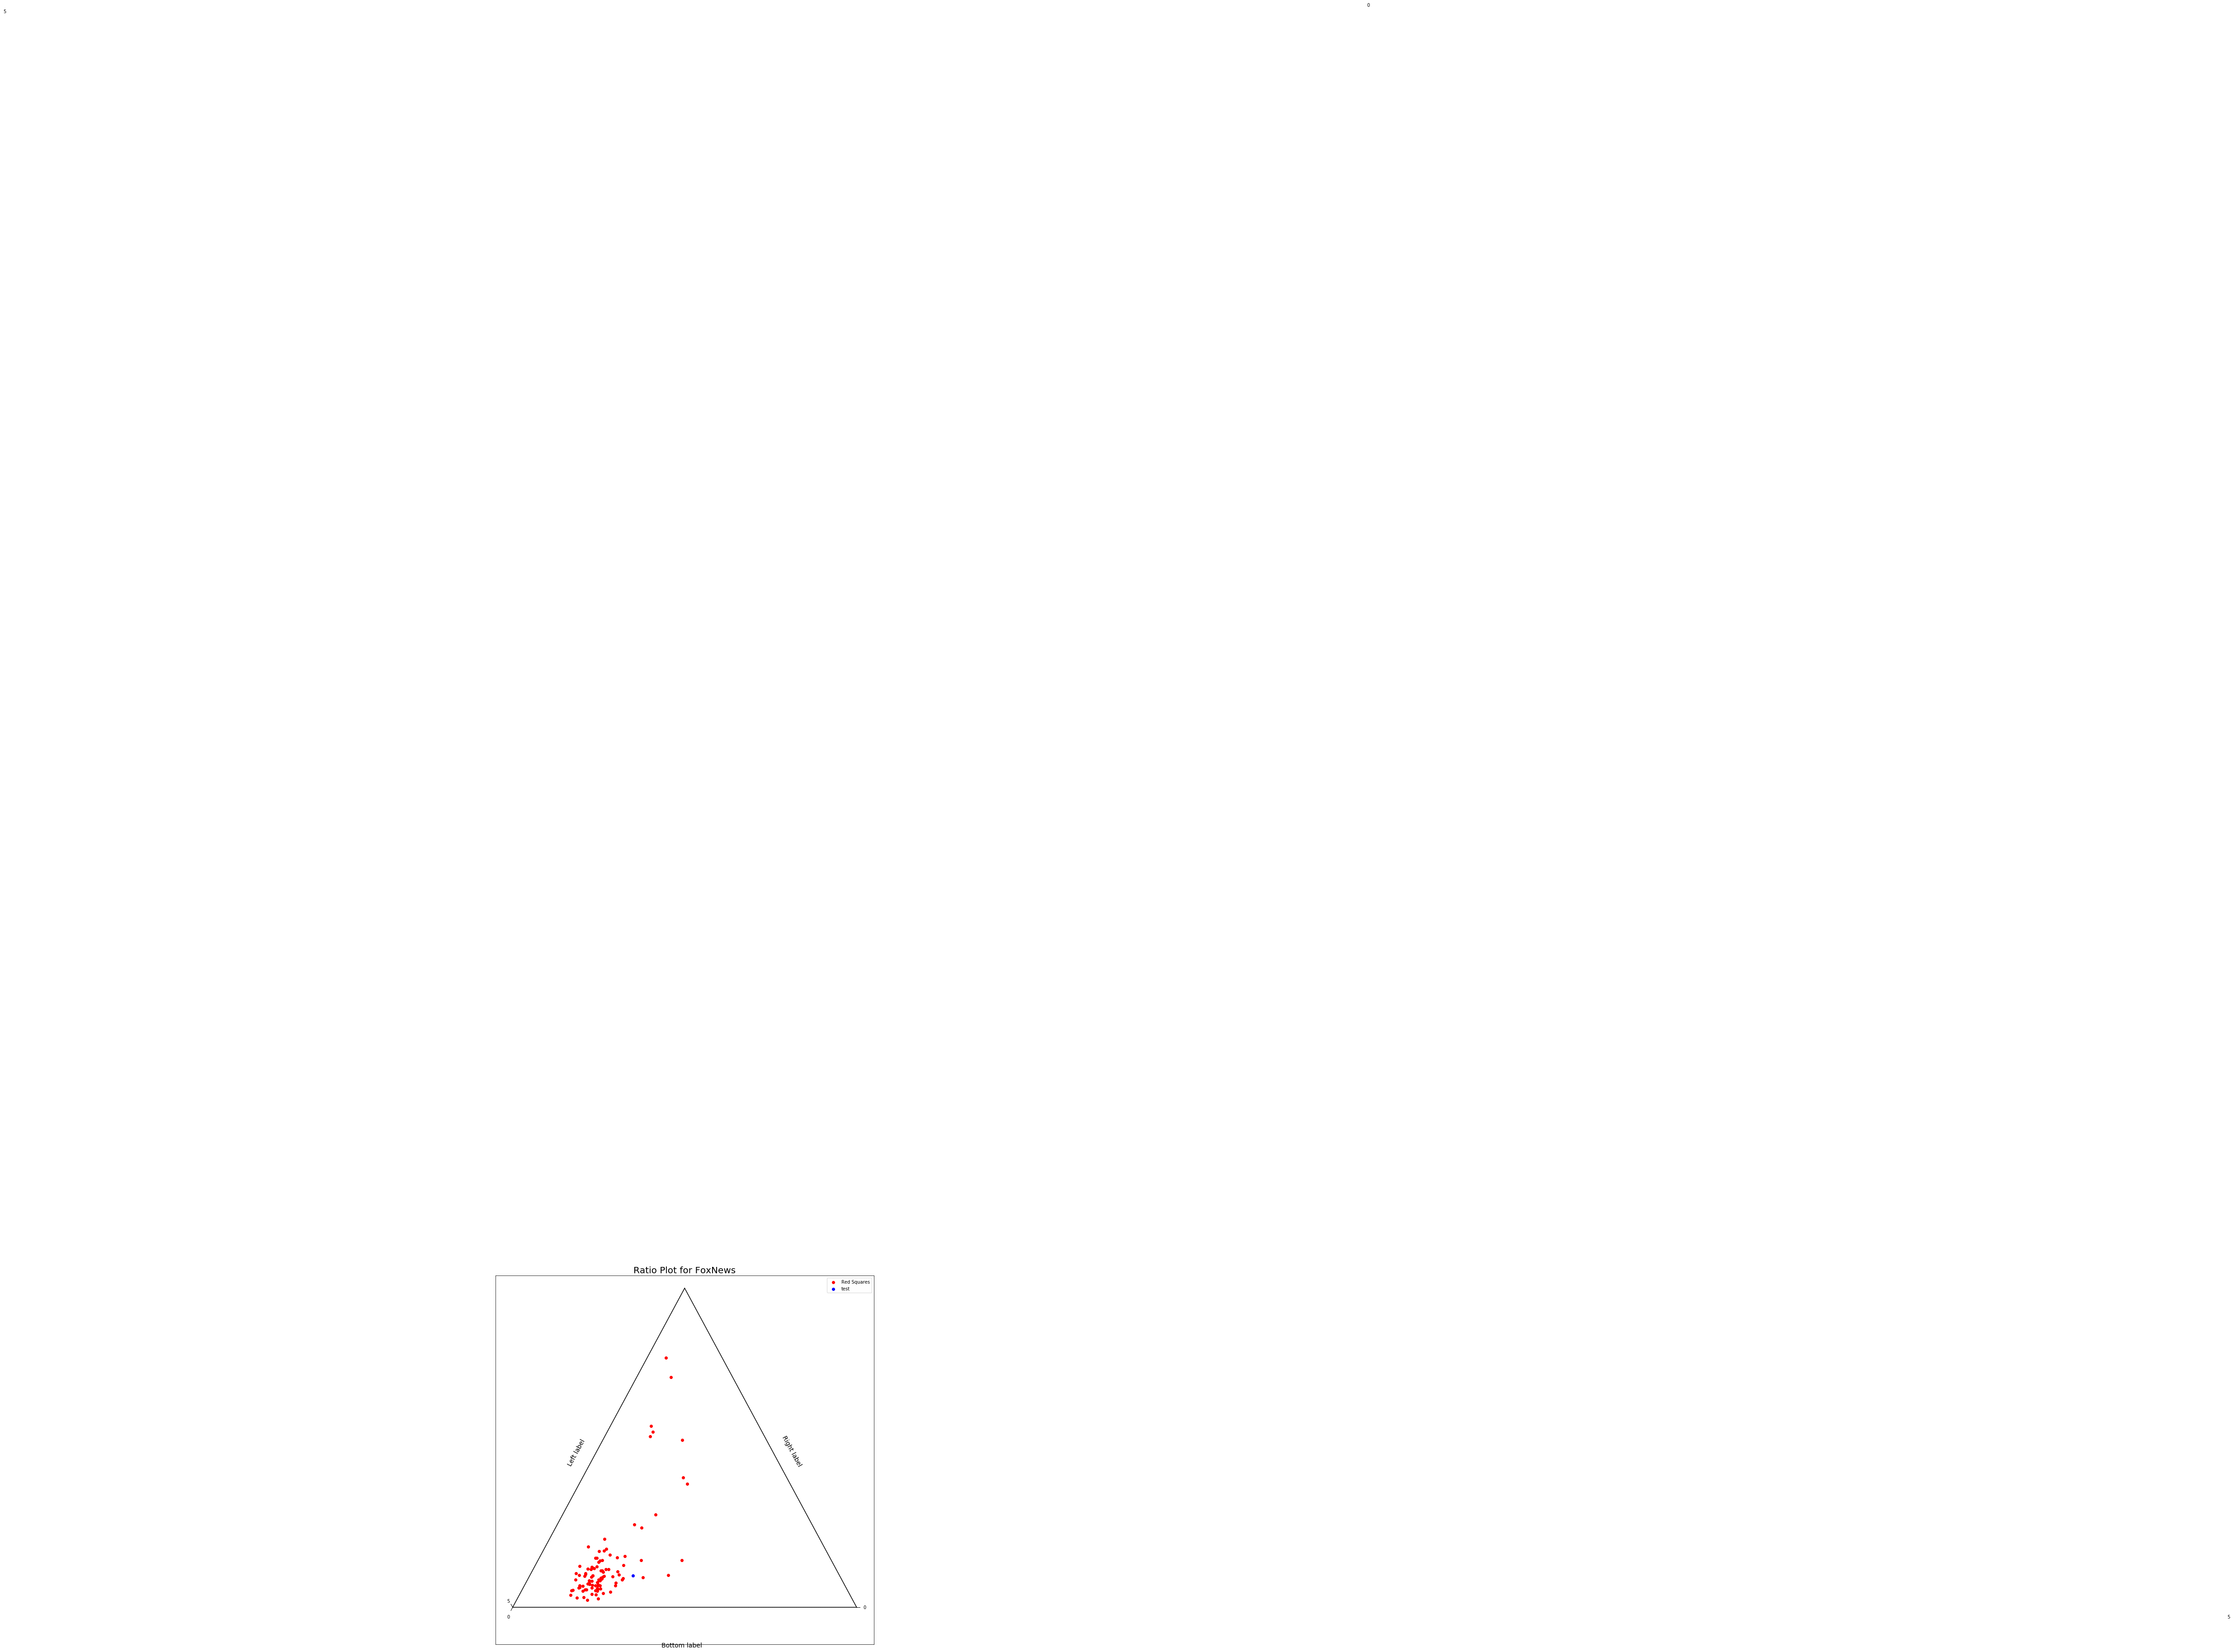

In [349]:
scale = 1

figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(15, 15)
# Set Axis labels and Title
tax.boundary(linewidth=1.5)
tax.gridlines(multiple=5, color="k")
tax.set_title("Ratio Plot for {}".format(screenname), fontsize=20)
tax.left_axis_label("Left label ", fontsize=14)
tax.right_axis_label("Right label ", fontsize=14)
tax.bottom_axis_label("Bottom label ", fontsize=14)

# Plot a few different styles with a legend
points = [i[0] for i in happ_tups]
tax.scatter(points, marker='o', color='red', label="Red Squares")
tax.scatter([(.3,.1,.6)],color='blue',label='test')
tax.legend()
tax.ticks(linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.savefig('taxplot.pdf')
tax.show()